In [1]:
from obspy.core import Stream, read
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 
from matplotlib.colors import Normalize
import pandas as pd
import os 
import os.path

In [2]:
path = '/Users/sydneydybing/StrainProject/2024/tohoku_strain_data/'

snr_array = pd.read_csv(path + 'stations_hypdists_snrs.list')
snr_array

,Station_name,latitude,longitude,azimuth(S1),azimuth(S2),azimuth(S3),azimuth(S4),hyp_dist_km,rms_snr
0,KST1,33.5201,135.8363,310,40,85,175,792.746765,1.273396
1,HGM1,33.8675,135.7318,337,67,112,202,773.809644,1.139778
2,ICU1,33.9001,136.1379,141,231,276,6,743.491829,1.203692
3,ANO1,34.7870,136.4019,38,128,173,263,661.251185,1.113420
4,SSK1,33.3896,133.3229,355,85,130,220,981.546244,1.285971
5,UWA1,33.3859,132.4823,222,312,357,87,1045.683453,1.282839
6,MUR1,33.2856,134.1563,147,237,282,12,927.200827,1.258307
7,MYM1,34.1123,136.1815,237,327,12,102,724.694237,1.134499


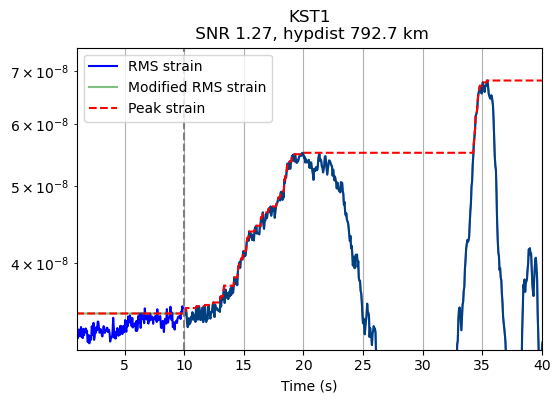

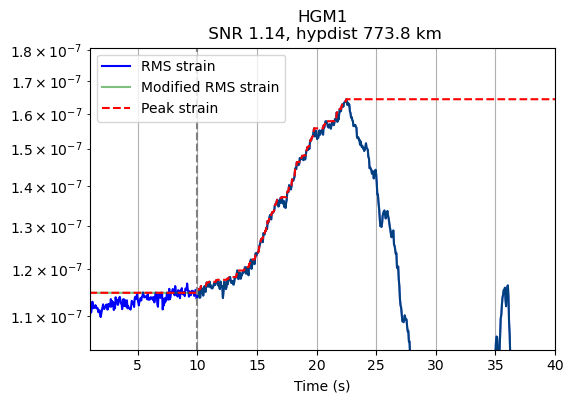

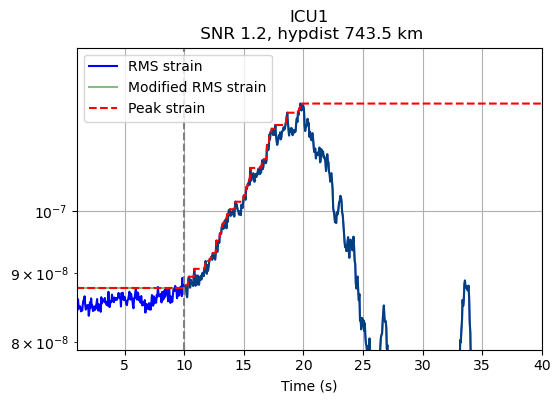

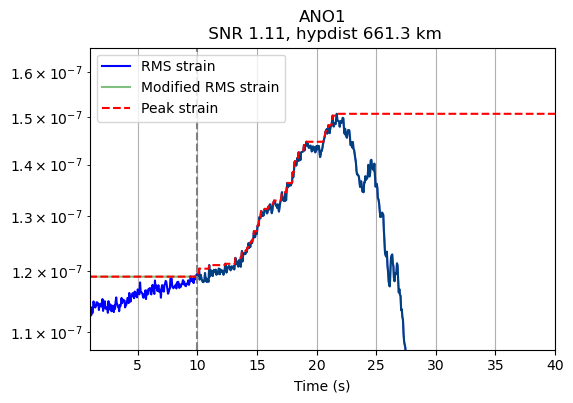

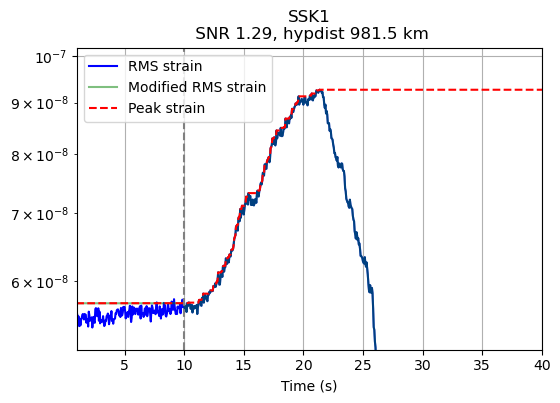

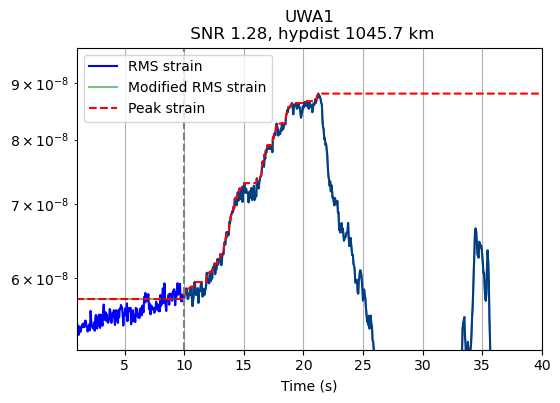

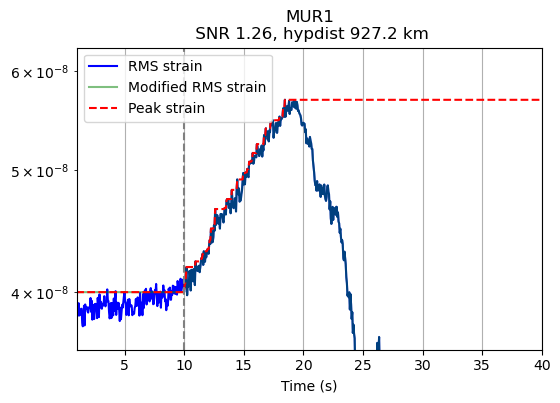

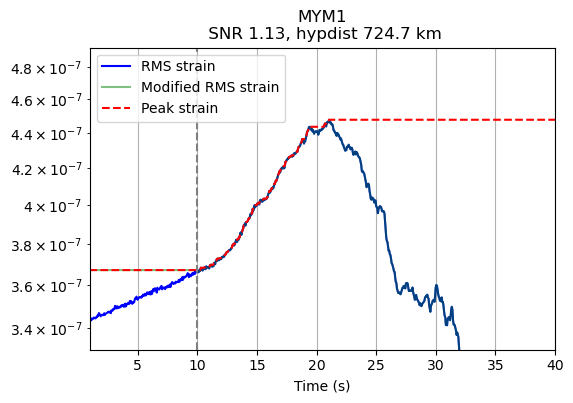

In [10]:
for i in range(len(snr_array)):
    
    sta = snr_array['Station_name'][i]
    hypdist = float(snr_array['hyp_dist_km'][i])
    snr = float(snr_array['rms_snr'][i])
        
    strain_waves = read(path + 'filtered_trimmed_rms/' + str(sta) + '.mseed') # RMS waveforms

    mod_strain = strain_waves.copy()

    strain_times = strain_waves[0].times()
    strain_data = strain_waves[0].data
    mod_strain_times = mod_strain[0].times()
    mod_strain_data = mod_strain[0].data

    samp_rate = strain_waves[0].stats.sampling_rate

    # Set the strain before the P-wave to the strain at the P-wave arrival
    p_arrival_strain = strain_data[int(10*samp_rate)]
    mod_strain_data[:int(10*samp_rate)] = p_arrival_strain

    # Calculate peak strain again on new modified RMS strain

    pst = mod_strain.copy()

    # Loop over samples
    for k in range(0,len(mod_strain[0].data)): #avoid starting at zero

        if k == 0:
            strain = mod_strain_data[0]
            max_strain = strain

        else:
            # Grab progressively longer windows and save the biggest strain
            strain = mod_strain_data[:k+1] # Has to be k+1 because slicing doesn't include last one
            max_strain = max(strain)

        # Put peak strain back into the output stream
        pst[0].data[k] = max_strain 

    pst_times = pst[0].times()
    pst_data = pst[0].data
    pst[0].stats.channel = 'PST' 

    # Plot how the new method looks to verify
    fig = plt.figure(dpi = 100, facecolor = 'white', num = 1, clear = True)
    ax = fig.add_subplot(111)
    ax.grid()
    ax.set_title(str(sta) + '\n SNR ' + str(round(snr,2)) + ', hypdist ' + str(round(hypdist,1)) + ' km')
    ax.plot(strain_times, strain_data, color = 'blue', label = 'RMS strain')
    ax.plot(strain_times, mod_strain_data, color = 'green', label = 'Modified RMS strain', alpha = 0.5)
    ax.plot(pst_times, pst_data, color = 'red', label = 'Peak strain', linestyle = '--')
#         ax.axhline(y = p_arrival_strain, color = 'orange')
    ax.set_yscale('log')
#     ax.set_ylabel('Log of peak extensional\nmicrostrain ($10^{-6}$)', fontsize = 15)
    ax.set_xlabel('Time (s)')
    ax.set_xlim(1,40)
    ax.set_ylim(min(pst_data[int(1*20):int(40*20)]*0.9), max(pst_data[int(1*20):int(40*20)])*1.1)
#     ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
    ax.axvline(x = 10, color = 'gray', linestyle = '--')
#             ax.tick_params(labelsize = 13)
    ax.legend(loc = 'upper left')
    plt.show()
    # plt.savefig(path_to_files + 'figures/new_peak_strain_plots_post_p_wave_examples/' + str(eq_id) + '_' + str(sta) + '.png', format = 'PNG')
    # plt.close();

    # Create folder for the event
    eq_sta_save_dir = path + 'filtered_peak_post_p/'
    # print(eq_sta_save_dir)
    if os.path.isdir(eq_sta_save_dir):
        pass
    else:
        os.makedirs(eq_sta_save_dir)

    pst.write(eq_sta_save_dir + sta + '.mseed', format = 'MSEED')
